In [1]:
import pandas as pd
import pylcs
import numpy as np
from tqdm.notebook import tqdm
import sklearn.svm
import sklearn.kernel_ridge
import plotly.express as px
import sklearn.metrics
import sklearn.model_selection
import sklearn.manifold
import optuna
import scipy

In [2]:
import pylcs
import fasta
from pathlib import Path
from math import log2
import numpy as np
from collections import Counter
import pandas as pd

In [3]:
input_file = "FLIP/meltome/splits/human_cell.csv"
# input_file = "FLIP/meltome/splits/mixed_split.csv"
# input_file = "FLIP/meltome/splits/human.csv"
# split_df = pd.read_csv("FLIP/meltome/splits/mixed_split.csv")
dataset_name = Path(input_file).stem
split_df = pd.read_csv(input_file)
split_df

,sequence,target,set,validation
0,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,41.945567,train,False
1,MALVFVYGTLKRGQPNHRVLRDGAHGSAAFRARGRTLEPYPLVIAG...,51.352307,test,False
2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,57.839199,test,False
3,MCSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPPPDFRGQWINLP...,51.721653,train,False
4,MSKEERPGREEILECQVMWEPDSKKNTQMDRFRAAVGAACGLALES...,43.020855,train,False
...,...,...,...,...
7153,MPEDQAGAAMEEASPYSLLDICLNFLTTHLEKFCSARQDGTLCLQE...,50.801858,train,False
7154,MASDTPESLMALCTDFCLRNLDGTLGYLLDKETLRLHPDIFLPSEI...,53.311340,train,False
7155,MAAPRPSPAISVSVSAPAFYAPQKKFGPVVAPKPKVNPFRPGDSEP...,60.921549,train,False
7156,MGNAPSHSSEDEAAAAGGEGWGPHQDWAAVSGTTPGPGVAAPALPP...,49.987949,test,False


In [4]:
sequence_lengths = [len(x) for x in split_df["sequence"].tolist()]
np.min(sequence_lengths), np.max(sequence_lengths), np.median(sequence_lengths)

(44, 34350, 469.0)

In [5]:
split_df[split_df["set"] == "test"]

,sequence,target,set,validation
1,MALVFVYGTLKRGQPNHRVLRDGAHGSAAFRARGRTLEPYPLVIAG...,51.352307,test,False
2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,57.839199,test,False
8,MESESESGAAADTPPLETLSFHGDEEIIEVVELDPGPPDPDDLAQE...,48.286298,test,False
11,MAFWCQRDSYAREFTTTVVSCCPAELQTEGSNGKKEVLSGFQVVLE...,47.725895,test,False
12,MTLQELVHKAASCYMDRVAVCFDECNNQLPVYYTYKTVVNAASELS...,47.951626,test,False
...,...,...,...,...
7143,MEFAAENEGKSGGGLHSVAEGVRLSPEPGREGVRDLAGAEEFGGGE...,43.069161,test,False
7144,MSVMDLANTCSSFQSDLDFCSDCGSVLPLPGAQDTVTCIRCGFNIN...,50.046440,test,False
7149,MMAADIPRVTTPLSSLVQVPQEEDRQEEEVTTMILEDDSWVQEAVL...,52.380485,test,False
7156,MGNAPSHSSEDEAAAAGGEGWGPHQDWAAVSGTTPGPGVAAPALPP...,49.987949,test,False


In [6]:
# rng = np.random.default_rng(23)
# train_size = 2**10
# test_size = 2**8
train_df = split_df[(split_df["set"] == "train") & (split_df["validation"] != True)]
# train_idx = rng.choice(len(train_df), size=train_size, replace=False)
# train_df = train_df.iloc[train_idx]
valid_df = split_df[(split_df["set"] == "train") & (split_df["validation"] == True)]
test_df = split_df[split_df["set"] == "test"]
# test_idx = rng.choice(len(test_df), size=test_size, replace=False)
# test_df = test_df.iloc[test_idx]

In [7]:
train_df

,sequence,target,set,validation
0,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,41.945567,train,False
3,MCSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPPPDFRGQWINLP...,51.721653,train,False
4,MSKEERPGREEILECQVMWEPDSKKNTQMDRFRAAVGAACGLALES...,43.020855,train,False
5,MRSSCVLLTALVALAAYYVYIPLPGSVSDPWKLMLLDATFRGAQQV...,60.513499,train,False
6,MNYARFITAASAARNPSPIRTMTDILSRGPKSMISLAGGLPNPNMF...,56.774612,train,False
...,...,...,...,...
7151,MWERLNCAAEDFYSRLLQKFNEEKKGIRKDPFLYEADVQVQLISKG...,48.740474,train,False
7152,MEAAETEAEAAALEVLAEVAGILEPVGLQEEAELPAKILVEFVVDS...,47.743331,train,False
7153,MPEDQAGAAMEEASPYSLLDICLNFLTTHLEKFCSARQDGTLCLQE...,50.801858,train,False
7154,MASDTPESLMALCTDFCLRNLDGTLGYLLDKETLRLHPDIFLPSEI...,53.311340,train,False


In [8]:
valid_df

,sequence,target,set,validation
43,MRKRTEPVALEHERCAAAGSSSSGSAAAALDADCRLKQNLRLTGPA...,53.032091,train,True
47,MADDLEQQSQGWLSSWLPTWRPTSMSQLKNVEARILQCLQNKFLAR...,44.226511,train,True
48,MAAEEEEVDSADTGERSGWLTGWLPTWCPTSISHLKEAEEKMLKCV...,49.116455,train,True
57,MAGTYSSTLKTLEDLTLDSGYGAGDSCRSLSLSSSKSNSQALNSSA...,42.949469,train,True
80,MSAKAISEQTGKELLYKFICTTSAIQNRFKYARVTPDTDWARLLQD...,50.648207,train,True
...,...,...,...,...
7051,MNASSEGESFAGSVQIPGGTTVLVELTPDIHICGICKQQFNNLDAF...,48.105416,train,True
7075,MEAEETMECLQEFPEHHKMILDRLNEQREQDRFTDITLIVDGHHFK...,45.869794,train,True
7102,MQAVVPLNKMTAISPEPQTLASTEQNEVPRVVTSGEQEAILRGNAA...,50.025723,train,True
7129,MAQASLLACEGLAGVSLVPTAASKKMMLSQIASKQAENGERAGSPD...,48.729643,train,True


In [9]:
test_df

,sequence,target,set,validation
1,MALVFVYGTLKRGQPNHRVLRDGAHGSAAFRARGRTLEPYPLVIAG...,51.352307,test,False
2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,57.839199,test,False
8,MESESESGAAADTPPLETLSFHGDEEIIEVVELDPGPPDPDDLAQE...,48.286298,test,False
11,MAFWCQRDSYAREFTTTVVSCCPAELQTEGSNGKKEVLSGFQVVLE...,47.725895,test,False
12,MTLQELVHKAASCYMDRVAVCFDECNNQLPVYYTYKTVVNAASELS...,47.951626,test,False
...,...,...,...,...
7143,MEFAAENEGKSGGGLHSVAEGVRLSPEPGREGVRDLAGAEEFGGGE...,43.069161,test,False
7144,MSVMDLANTCSSFQSDLDFCSDCGSVLPLPGAQDTVTCIRCGFNIN...,50.046440,test,False
7149,MMAADIPRVTTPLSSLVQVPQEEDRQEEEVTTMILEDDSWVQEAVL...,52.380485,test,False
7156,MGNAPSHSSEDEAAAAGGEGWGPHQDWAAVSGTTPGPGVAAPALPP...,49.987949,test,False


In [10]:
len(train_df), len(valid_df), len(test_df)

(5149, 643, 1366)

In [11]:
# Export sequences to text file in order to compute LCS in parallel
# After runnig this cell, use the pairwise_distances.py script to compute (upper triangular part of symmetric) LCS matrices.
# The script supports options for computing submatrices, to be used for distributing the computation on a cluster. The simplest example is:
# $ python3 pairwise_distances.py sequences_FLIP_human_cell.txt sequences_FLIP_human_cell.npy
# Then use the notebook "Assemble Distance Matrices.npy" to assemble submatrices and compute the 
# lower triangular entries. Output the result into a file "lcs_FLIP_human_cell.npy"

all_sequences = [x.sequence for x in split_df.itertuples()]
with open(f"sequences_FLIP_{dataset_name}.txt", "w+") as fh:
    for seq in all_sequences:
        fh.write(seq)
        fh.write("\n")

In [12]:
# This cell assumes that LCS matrices have been generated using the external script, as described in the previous cell

lcs_matrix = np.load(f"lcs_FLIP_{dataset_name}.npy").astype("uint16")

In [13]:
harmonic_series = np.hstack([[0], np.cumsum(1/np.arange(1, 2**20))])
def compute_harmonic_edit_distance(la, lb, lcs):
    return 2*harmonic_series[la+lb-lcs] - harmonic_series[la] - harmonic_series[lb]

def compute_edit_distance(la, lb, lcs):
    return la+lb-2*lcs

def compute_steinhaus_distance(la, lb, lcs):
    ed = compute_edit_distance(la, lb, lcs)
    return 2*ed / (la + lb + ed)

def extract_lcs(lcs_matrix, row_df, col_df):
    row_seqs = [x.sequence for x in row_df.itertuples()]
    col_seqs = [x.sequence for x in col_df.itertuples()]
    lcs = np.zeros((len(row_seqs), len(col_seqs)), dtype="uint16")
    col_idx = np.array(col_df.index.values, dtype=int)
    for i in range(len(row_seqs)):
            k_i = row_df.index[i]
            lcs[i, :] = lcs_matrix[k_i, col_idx]
    return lcs

def extract_dataset(lcs_matrix, train_df, df):
    dataset = {}
    dataset["sequences"] = [x.sequence for x in df.itertuples()]
    dataset["lengths"] = np.array([len(x) for x in dataset["sequences"]])
    train_lengths = np.array([len(x.sequence) for x in train_df.itertuples()])
    dataset["target"] = df["target"]
    dataset["lcs"] = extract_lcs(lcs_matrix, df, train_df).astype("uint16")
    dataset["harmonic_distance"] = compute_harmonic_edit_distance(
        dataset["lengths"][:, None], 
        train_lengths[None, :], 
        dataset["lcs"]
    )
    dataset["edit_distance"] = compute_edit_distance(
        dataset["lengths"][:, None], 
        train_lengths[None, :], 
        dataset["lcs"]
    )
    dataset["steinhaus_distance"] = compute_steinhaus_distance(
        dataset["lengths"][:, None], 
        train_lengths[None, :], 
        dataset["lcs"]
    )
    return dataset

In [14]:
train = extract_dataset(lcs_matrix, train_df, train_df)
valid = extract_dataset(lcs_matrix, train_df, valid_df)
test = extract_dataset(lcs_matrix, train_df, test_df)

In [15]:
train["lcs"].nbytes / 2**20

50.568010330200195

In [16]:
train["harmonic_distance"].nbytes / 2**20

202.27204132080078

In [17]:
import optuna
import optuna.samplers

In [18]:
def eval_parameters(params, distance_key, train, eval):
    gamma = params["gamma"]
    C = params["C"]

    train["kernel"] = np.exp(-gamma*train[distance_key]**2)
    eval["kernel"] = np.exp(-gamma*eval[distance_key]**2)

    classifier = sklearn.svm.SVR(C=C, kernel="precomputed", verbose=False, shrinking=False, max_iter=2**16)
    classifier.fit(train["kernel"], train["target"])

    prediction = classifier.predict(eval["kernel"])
    # valid_accuracy = sklearn.metrics.accuracy_score(eval["target"], prediction)

    valid_spearman = scipy.stats.spearmanr(prediction, eval["target"]).statistic
    return valid_spearman

In [19]:
def objective(trial, distance_key, train, eval, gamma_range=[1e-1, 1e1]):
    params = {}
    params["gamma"] = trial.suggest_float("gamma", gamma_range[0], gamma_range[1], log=True)
    params["C"] = trial.suggest_float("C", 1e-2, 1e2, log=True)
    val = eval_parameters(params, distance_key, train, eval)
    return -val

In [20]:
eval_parameters({"C": 1, "gamma": 1}, "steinhaus_distance", train, valid)

0.43057616718755853

In [21]:
def objective_harmonic(trial):
    return objective(trial, "harmonic_distance", train, valid, gamma_range=[1e-1, 1e1])

def objective_edit(trial):
    return objective(trial, "edit_distance", train, valid, gamma_range=[1e-4, 1e-2])

def objective_steinhaus(trial):
    return objective(trial, "steinhaus_distance", train, valid, gamma_range=[1e-1, 1e1])

In [22]:
studies = {}
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=23))
study.optimize(objective_harmonic, n_trials=32)
studies["harmonic"] = study

[I 2024-08-07 17:09:53,815] A new study created in memory with name: no-name-fbbd0dc9-b72d-4194-9623-f2088b7ae612
/Users/bob/venv/python3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=65536).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
[I 2024-08-07 17:09:56,962] Trial 0 finished with value: 0.005451879088899447 and parameters: {'gamma': 1.0829184866889259, 'C': 61.35506425409843}. Best is trial 0 with value: 0.005451879088899447.
[I 2024-08-07 17:09:57,247] Trial 1 finished with value: -0.32636508988222596 and parameters: {'gamma': 3.395623408235136, 'C': 0.1347669426130217}. Best is trial 1 with value: -0.32636508988222596.
[I 2024-08-07 17:09:57,647] Trial 2 finished with value: 0.08529833065105805 and parameters: {'gamma': 0.27675197352313574, 'C': 5.557613501759315}. Best is trial 1 with value: -0.32636508988222596.
[I 2024-08-07 17:09:57,932] Trial 3 finished with value:

KeyboardInterrupt: 

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=23))
study.optimize(objective_edit, n_trials=32)
studies["edit"] = study

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=23))
study.optimize(objective_steinhaus, n_trials=32)
studies["steinhaus"] = study

In [ ]:
eval_parameters(studies["harmonic"].best_params, "harmonic_distance", train=train, eval=test)

In [ ]:
eval_parameters(studies["edit"].best_params, "edit_distance", train=train, eval=test)

In [ ]:
eval_parameters(studies["steinhaus"].best_params, "steinhaus_distance", train=train, eval=test)

In [ ]:
{k: v.best_params for k, v in studies.items()}

In [23]:
tsne = sklearn.manifold.TSNE(metric="precomputed", n_iter=2**13, init="random", n_jobs=-1, verbose=True, random_state=42)
coordinates = {}
coordinates["harmonic"] = tsne.fit_transform(train["harmonic_distance"])


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5149 samples in 0.016s...
[t-SNE] Computed neighbors for 5149 samples in 0.214s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5149
[t-SNE] Computed conditional probabilities for sample 2000 / 5149
[t-SNE] Computed conditional probabilities for sample 3000 / 5149
[t-SNE] Computed conditional probabilities for sample 4000 / 5149
[t-SNE] Computed conditional probabilities for sample 5000 / 5149
[t-SNE] Computed conditional probabilities for sample 5149 / 5149
[t-SNE] Mean sigma: 0.130571
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.661522
[t-SNE] KL divergence after 8192 iterations: 1.891862


In [24]:
tsne = sklearn.manifold.TSNE(metric="precomputed", n_iter=2**11, init="random", n_jobs=-1, verbose=True, random_state=42)
coordinates["edit"] = tsne.fit_transform(train["edit_distance"])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5149 samples in 0.008s...
[t-SNE] Computed neighbors for 5149 samples in 0.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5149
[t-SNE] Computed conditional probabilities for sample 2000 / 5149
[t-SNE] Computed conditional probabilities for sample 3000 / 5149
[t-SNE] Computed conditional probabilities for sample 4000 / 5149
[t-SNE] Computed conditional probabilities for sample 5000 / 5149
[t-SNE] Computed conditional probabilities for sample 5149 / 5149
[t-SNE] Mean sigma: 54.059876
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.235718
[t-SNE] KL divergence after 2048 iterations: 3.486958


In [25]:
tsne = sklearn.manifold.TSNE(metric="precomputed", n_iter=2**11, init="random", n_jobs=-1, verbose=True, random_state=42)
coordinates["steinhaus"] = tsne.fit_transform(train["steinhaus_distance"])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5149 samples in 0.010s...
[t-SNE] Computed neighbors for 5149 samples in 0.240s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5149
[t-SNE] Computed conditional probabilities for sample 2000 / 5149
[t-SNE] Computed conditional probabilities for sample 3000 / 5149
[t-SNE] Computed conditional probabilities for sample 4000 / 5149
[t-SNE] Computed conditional probabilities for sample 5000 / 5149
[t-SNE] Computed conditional probabilities for sample 5149 / 5149
[t-SNE] Mean sigma: 0.089259
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.892639
[t-SNE] KL divergence after 2048 iterations: 2.250279


In [26]:
import plotly.graph_objs as go
traces = []
label_colors = train["target"]
text = train["target"]
for distance, coords in coordinates.items():
    traces.append({"x": coords[:, 0], "y": coords[:, 1], "name": distance, "type": "scatter", "mode": "markers", "text": text, "marker": {"size": 4, "color": label_colors}})
layout = {"coloraxis": {"showscale": True}}
# go.Figure(data=traces[0:1], layout=layout).show()
# go.Figure(data=traces[1:2], layout=layout).show()

In [27]:
import matplotlib.pyplot as plt

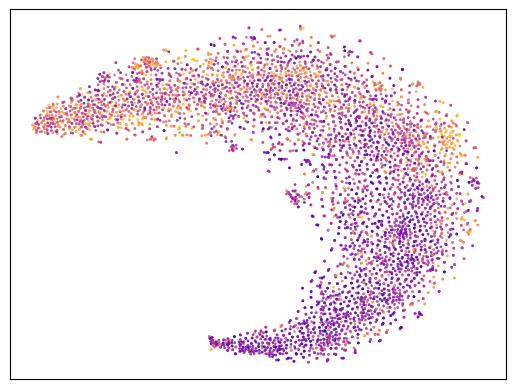

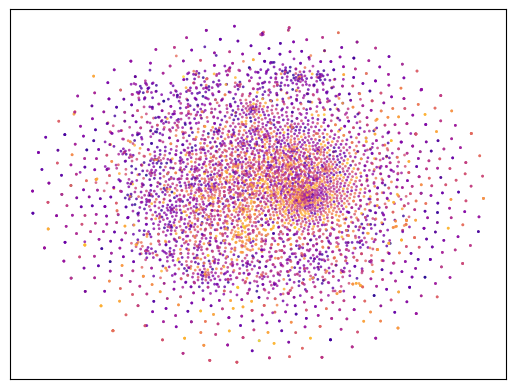

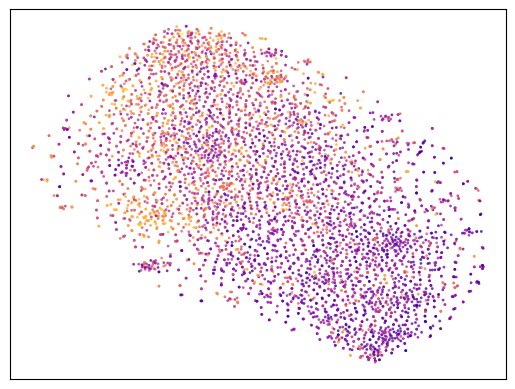

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.colormaps["plasma"]
for trace in traces: #trace = traces[0]
    fig, ax = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(x=trace["x"], y=trace["y"], c=trace["marker"]["color"], s=trace["marker"]["size"], alpha=0.8, edgecolor="none", cmap=cmap)
    plt.savefig(f"TSNE_{dataset_name}_{trace['name']}.png", dpi=600, bbox_inches="tight")

In [ ]:
help(plt.savefig)